### Week 10
### DSC 650
### Abed Tabbalat

In [1]:
# Mounting drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/DSC650/Original/dsc650/assignments/assignment10')
!pwd

Mounted at /content/drive
/content/drive/My Drive/DSC650/Original/dsc650/assignments/assignment10


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from pathlib import Path
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop

## Assignment 10.1

#### Assignment 10.1a


In [3]:
def tokenize(sentence):
    """
    Splits a sentence into words, converts them to lowercase, and removes punctuation.

    Args:
        sentence (str): The sentence to tokenize.

    Returns:
        A list of strings representing the tokens.
    """
    tokens = []
    
    # Split sentence into words
    words = sentence.split()
    
    # Convert words to lowercase
    words = [word.lower() for word in words]
    
    # Remove punctuation from each word
    translator = str.maketrans('', '', string.punctuation)
    tokens = [word.translate(translator) for word in words]

    return tokens

In [4]:
sentence = 'The greatest glory in living lies not in never falling, but in rising every time we fall.'
words_token = tokenize(sentence)
print(words_token)

['the', 'greatest', 'glory', 'in', 'living', 'lies', 'not', 'in', 'never', 'falling', 'but', 'in', 'rising', 'every', 'time', 'we', 'fall']


#### Assignment 10.1c

In [5]:
def one_hot_encode(tokens, num_words=100):
    """
    One-hot encodes a list of tokens.

    Args:
        tokens (list): A list of strings representing the tokens to be encoded.
        num_words (int, optional): The maximum number of words to consider in the encoding. Defaults to 100.

    Returns:
        A 3D numpy array of shape (num_tokens, max_length, num_words+1), where num_tokens is the number of tokens,
        max_length is the maximum length of a token sequence, and num_words+1 is the size of the vocabulary (plus 1 for
        the padding token).
    """
    # Create a dictionary mapping each unique token to a unique integer index
    token_index = {}
    for word in tokens:
        if word not in token_index:
            token_index[word] = len(token_index) + 1  # We add 1 to the index because 0 is reserved for the padding token
    
    # Set the maximum length of a token sequence to 10
    max_length = 10
    
    # Initialize a 3D numpy array to hold the one-hot encoded tokens
    results = np.zeros(shape=(len(tokens), max_length, max(token_index.values()) + 1))  # We add 1 to the vocabulary size to account for the padding token
    
    # Iterate over the tokens and their indices, and encode them one-hot
    for i, word in enumerate(tokens):
        for j, word in list(enumerate(tokens))[:max_length]:  # We use list(enumerate()) to limit the number of words to max_length
            index = token_index.get(word)
            results[i, j, index] = 1  # Set the corresponding entry to 1 for the one-hot encoding
    
    return results

In [6]:
words_one_hot = one_hot_encode(words_token)
print(words_one_hot[1:10])

[[[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


## Assignment 10.2

In [7]:
# Set the current directory to an absolute path
current_dir = Path(os.getcwd()).absolute()

# Set the path to the IMDB dataset
imdb_dir = '../../../data/external/imdb/aclImdb'

# Set the paths to the train and test directories of the IMDB dataset
train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')

# Process the labels and texts from the raw IMDB data
labels = []   # A list to hold the labels (0 for negative, 1 for positive)
texts = []    # A list to hold the text data

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)

    # Iterate over the files in the directory and extract the text data
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()

            # Set the corresponding label (0 for negative, 1 for positive)
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [8]:
# Set the maximum length of a review to 100 words
maxlen = 100

# Set the number of samples to use for training
training_samples = 200

# Set the number of samples to use for validation
validation_samples = 10000

# Consider only the top 10000 words in the dataset
max_words = 10000

# Create a tokenizer object and fit it on the texts
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

# Convert the texts to sequences of integers
sequences = tokenizer.texts_to_sequences(texts)

# Get the word index from the tokenizer and print the number of unique tokens
word_index = tokenizer.word_index
print(f'Unique Tokens: {len(word_index)} ')

Unique Tokens: 88582 


In [9]:
data = pad_sequences(sequences, maxlen = maxlen)


labels = np.asarray(labels)
print(f'Data tensor: {data.shape}')
print(f'Label tensor: {labels.shape}')

Data tensor: (25000, 100)
Label tensor: (25000,)


In [10]:
# Shuffle the indices of the data and labels arrays
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Split the data and labels into training and validation sets
x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# Train the model
embedding_dim = 100   # Set the dimension of the embedding space

# Create a sequential model
model = Sequential()

# Add an embedding layer
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

# Add a flattening layer
model.add(Flatten())

# Add a dense layer with 32 units and a ReLU activation function
model.add(Dense(32, activation='relu'))

# Add a dense layer with 1 unit and a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model with the RMSprop optimizer, binary cross-entropy loss function, and accuracy metric
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Train the model on the training data and evaluate it on the validation data
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 3s 258ms/step - loss: 0.6909 - acc: 0.5300 - val_loss: 0.6919 - val_acc: 0.5136
Epoch 2/10
7/7 [==============================] - 2s 351ms/step - loss: 0.5674 - acc: 0.9600 - val_loss: 0.6918 - val_acc: 0.5217
Epoch 3/10
7/7 [==============================] - 2s 317ms/step - loss: 0.4226 - acc: 0.9800 - val_loss: 0.6955 - val_acc: 0.5225
Epoch 4/10
7/7 [==============================] - 2s 252ms/step - loss: 0.2564 - acc: 1.0000 - val_loss: 0.6971 - val_acc: 0.5270
Epoch 5/10
7/7 [==============================] - 1s 212ms/step - loss: 0.1467 - acc: 1.0000 - val_loss: 0.7009 - val_acc: 0.5289
Epoch 6/10
7/7 [==============================] - 2s 270ms/step - loss: 0.0841 - acc: 1.0000 - val_loss: 0.7099 - val_acc: 0.5288
Epoch 7/10
7/7 [==============================] - 2s 248ms/step - loss: 0.0507 - acc: 1.0000 - val_loss: 0.7162 - val_acc: 0.5315
Epoch 8/10
7/7 [==============================] - 1s 194ms/step - loss: 0.0325 - acc: 1.00

In [12]:
# Process the labels and texts from the test data
labels = []   # A list to hold the labels (0 for negative, 1 for positive)
texts = []    # A list to hold the text data

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)

    # Iterate over the files in the directory and extract the text data
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()

            # Set the corresponding label (0 for negative, 1 for positive)
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

# Convert the texts to sequences of integers and pad them to a fixed length
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)

# Convert the labels to a numpy array
y_test = np.asarray(labels)

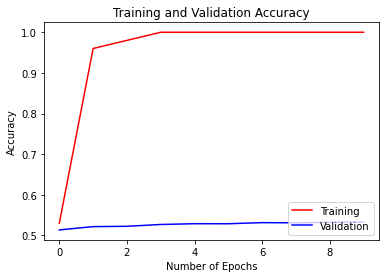

In [13]:
# Plot the training and validation accuracy curves
plt.plot(history.history['acc'], color='red')   # Red line for training accuracy
plt.plot(history.history['val_acc'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')

# Add a legend to the plot
plt.legend(['Training', 'Validation'], loc='lower right')

# Show the plot
plt.show()

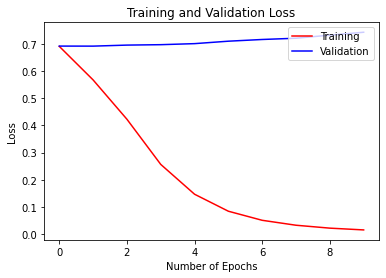

In [14]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], color='red')   # Red line for training loss
plt.plot(history.history['val_loss'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')

# Add a legend to the plot
plt.legend(['Training', 'Validation'], loc='upper right')

# Show the plot
plt.show()

In [15]:
# Evaluate the model on the test data
eval = model.evaluate(x_test, y_test)

# Print the model's accuracy and loss on the test data
print(f'Model Accuracy: {eval[1] * 100:.1f}%')
print(f'Model Loss: {eval[0]:.3f}')

782/782 [==============================] - 2s 3ms/step - loss: 0.7509 - acc: 0.5242
Model Accuracy: 52.4%
Model Loss: 0.751


## Assignment 10.3

In [16]:
# Set the number of words to consider as features
max_features = 10000

# Create a sequential model with an embedding layer, LSTM layer, and dense layer
model = Sequential()

# Add an embedding layer with 32-dimensional vectors
model.add(Embedding(max_features, 32))

# Add an LSTM layer with 32 units
model.add(LSTM(32))

# Add a dense layer with a single unit and a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model with the RMSprop optimizer, binary cross-entropy loss function, and accuracy metric
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Train the model on the training data with 10 epochs, a batch size of 128, and a validation split of 0.2
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 4s 666ms/step - loss: 0.6944 - acc: 0.3938 - val_loss: 0.6920 - val_acc: 0.6000
Epoch 2/10
2/2 [==============================] - 0s 165ms/step - loss: 0.6925 - acc: 0.5562 - val_loss: 0.6912 - val_acc: 0.6500
Epoch 3/10
2/2 [==============================] - 0s 184ms/step - loss: 0.6913 - acc: 0.6187 - val_loss: 0.6901 - val_acc: 0.5500
Epoch 4/10
2/2 [==============================] - 0s 167ms/step - loss: 0.6900 - acc: 0.5375 - val_loss: 0.6892 - val_acc: 0.5500
Epoch 5/10
2/2 [==============================] - 0s 169ms/step - loss: 0.6888 - acc: 0.5188 - val_loss: 0.6893 - val_acc: 0.5500
Epoch 6/10
2/2 [==============================] - 0s 184ms/step - loss: 0.6874 - acc: 0.5938 - val_loss: 0.6884 - val_acc: 0.5500
Epoch 7/10
2/2 [==============================] - 0s 282ms/step - loss: 0.6855 - acc: 0.5500 - val_loss: 0.6873 - val_acc: 0.5500
Epoch 8/10
2/2 [==============================] - 0s 271ms/step - loss: 0.6832 - acc: 0.55

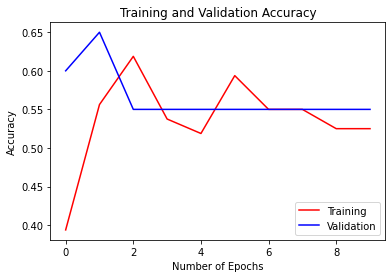

In [18]:
# Plot the training and validation accuracy curves
plt.plot(history.history['acc'], color='red')   # Red line for training accuracy
plt.plot(history.history['val_acc'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')

# Add a legend to the plot
plt.legend(['Training', 'Validation'], loc='lower right')

# Show the plot
plt.show()

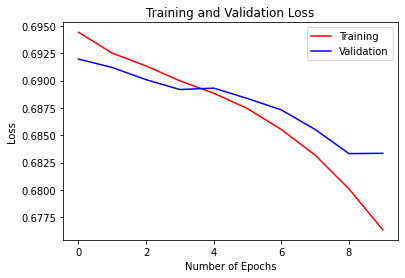

In [19]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], color='red')   # Red line for training loss
plt.plot(history.history['val_loss'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')

# Add a legend to the plot
plt.legend(['Training', 'Validation'], loc='upper right')

# Show the plot
plt.show()

In [20]:
# Evaluate the model on the test data
eval = model.evaluate(x_test, y_test)

# Print the model's accuracy and loss on the test data
print(f'Model Accuracy: {eval[1] * 100:.1f}%')
print(f'Model Loss: {eval[0]:.3f}')

782/782 [==============================] - 4s 6ms/step - loss: 0.6914 - acc: 0.5035
Model Accuracy: 50.4%
Model Loss: 0.691


## Assignment 10.4

In [21]:
# Set the maximum length of input sequences
max_len = 100

# Create a sequential model with an embedding layer, two convolutional layers, a global max pooling layer, and a dense layer
model = Sequential()

# Add an embedding layer with 128-dimensional vectors
model.add(Embedding(max_features, 128, input_length=max_len))

# Add a 1D convolutional layer with 32 filters, a kernel size of 7, and a ReLU activation function
model.add(Conv1D(32, 7, activation='relu'))

# Add a max pooling layer with a pool size of 5
model.add(MaxPooling1D(5))

# Add another 1D convolutional layer with 32 filters, a kernel size of 7, and a ReLU activation function
model.add(Conv1D(32, 7, activation='relu'))

# Add a global max pooling layer
model.add(GlobalMaxPooling1D())

# Add a dense layer with a single unit
model.add(Dense(1))

# Print a summary of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 94, 32)            28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 1)                

In [22]:
# Compile the model with the RMSprop optimizer with a learning rate of 1e-4, binary cross-entropy loss function, and accuracy metric
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the model on the training data with 10 epochs, a batch size of 128, and a validation split of 0.2
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 7s 535ms/step - loss: 1.0655 - acc: 0.5188 - val_loss: 0.8813 - val_acc: 0.5500
Epoch 2/10
2/2 [==============================] - 0s 161ms/step - loss: 0.8988 - acc: 0.5188 - val_loss: 0.8380 - val_acc: 0.5500
Epoch 3/10
2/2 [==============================] - 0s 176ms/step - loss: 0.8285 - acc: 0.5188 - val_loss: 0.8109 - val_acc: 0.5500
Epoch 4/10
2/2 [==============================] - 0s 165ms/step - loss: 0.7837 - acc: 0.5188 - val_loss: 0.7923 - val_acc: 0.5500
Epoch 5/10
2/2 [==============================] - 0s 162ms/step - loss: 0.7512 - acc: 0.5188 - val_loss: 0.7758 - val_acc: 0.5500
Epoch 6/10
2/2 [==============================] - 0s 167ms/step - loss: 0.7232 - acc: 0.5188 - val_loss: 0.7657 - val_acc: 0.5500
Epoch 7/10
2/2 [==============================] - 0s 164ms/step - loss: 0.7021 - acc: 0.5188 - val_loss: 0.7561 - val_acc: 0.5500
Epoch 8/10
2/2 [==============================] - 0s 164ms/step - loss: 0.6827 - acc: 0.51

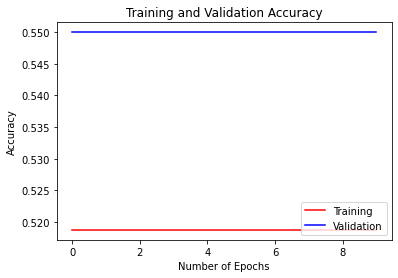

In [23]:
# Plot the training and validation accuracy curves
plt.plot(history.history['acc'], color='red')   # Red line for training accuracy
plt.plot(history.history['val_acc'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')

# Add a legend to the plot
plt.legend(['Training', 'Validation'], loc='lower right')

# Show the plot
plt.show()

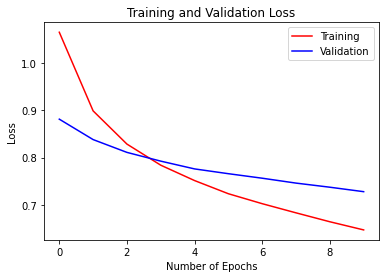

In [24]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], color='red')   # Red line for training loss
plt.plot(history.history['val_loss'], color='blue')

# Set the title and axis labels
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')

# Add a legend to the plot
plt.legend(['Training', 'Validation'], loc='upper right')

# Show the plot
plt.show()

In [25]:
# Evaluate the model on the test data
eval = model.evaluate(x_test, y_test)

# Print the model's accuracy and loss on the test data
print(f'Model Accuracy: {eval[1] * 100:.1f}%')   # Display accuracy to one decimal place
print(f'Model Loss: {eval[0]:.3f}')   # Display loss to three decimal places

782/782 [==============================] - 2s 3ms/step - loss: 0.7765 - acc: 0.5000
Model Accuracy: 50.0%
Model Loss: 0.777
